# Imports

In [1]:
import numpy as np
import time
import pyscf
from pyscf import dft, scf
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from pyscf import gto, lo, tools, dft 
import py3Dmol
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 1. SMILES strings

## (a)

COc1cc(C=O)ccc1O

## (b)

Since nodes appear in the string in the order that they are visited by DFS, a 
different root node will produce a different order, and thus a different string.

# 2. PySCF calculations
## (a)

In [2]:
smiles = 'COc1cc(C=O)ccc1O'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

In [3]:
def show(mol):
    style = 'stick'
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=1000)
    mblock = Chem.MolToMolBlock(mol)
    view = py3Dmol.view(width=200, height=200)
    view.addModel(mblock, 'mol')
    view.setStyle({style:{}})
    view.zoomTo()
    view.show()
show(mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [21]:
def m2m(mol):
    elements = [atom.GetSymbol() for atom in mol.GetAtoms()]
    coordinates = mol.GetConformer().GetPositions()
    atoms = [(element, coordinate) for element, coordinate in zip(elements, coordinates)]
    
    pyscf_mole = gto.Mole()
    pyscf_mole.atom = atoms
    pyscf_mole.build()

    return pyscf_mole

def rks(mol):    
    mf = dft.RKS(mol)
    mf.run();

In [22]:
rks(m2m(mol))

converged SCF energy = -523.934184341746


## (b)

In [23]:
def make_water(n=3):
    # Function to create a single water molecule
    def h2o():
        mol = Chem.MolFromSmiles('O')
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        return mol
    
    # Create a new empty editable molecule
    water = Chem.RWMol()
    
    # Initialize positions
    x_offset = 100.0  # angstroms
    current_position = 0.0
    
    # Create and position 10 water molecules
    for i in range(n):
        single = h2o()
        conf = single.GetConformer()
        for atom_idx in range(single.GetNumAtoms()):
            pos = conf.GetAtomPosition(atom_idx)
            conf.SetAtomPosition(atom_idx, Chem.rdGeometry.Point3D(pos.x + current_position, pos.y, pos.z))
        water.InsertMol(single)
        current_position += x_offset

    return water

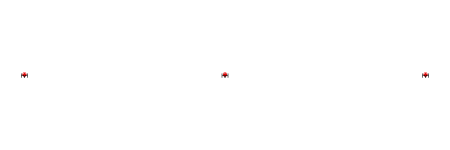

In [24]:
make_water(3)

In [25]:
# do as many as we can until the time runs out
def make_stats(f, maxiter, maxtime_sec):
    loop_start = time.time()
    times = []
    sizes = []
    for i in range(1,maxiter):
        if time.time() - loop_start > maxtime_sec:
            print('tl exceeded')
            break
        mol = make_water(i)
        start = time.time()

        elements = [atom.GetSymbol() for atom in mol.GetAtoms()]
        coordinates = mol.GetConformer().GetPositions()
        atoms = [(element, coordinate) for element, coordinate in zip(elements, coordinates)]
        pyscf_mole = gto.Mole()
        pyscf_mole.atom = atoms
        pyscf_mole.build()
    
        f(pyscf_mole)
        times.append(time.time() - loop_start)
        sizes.append(i)
    return times, sizes

In [26]:
times, sizes = make_stats(rks, 50, 300)

converged SCF energy = -74.7344045733968
converged SCF energy = -149.472453301329
converged SCF energy = -224.208495929027
converged SCF energy = -298.947871131945
converged SCF energy = -373.667865092678
converged SCF energy = -448.409876914525


KeyboardInterrupt: 

In [27]:
def plot_comp(sizes, times, method):
    def exp(x, a, b): return a * (x ** b)
    p, cov = curve_fit(exp, sizes, times)
    plt.plot(sizes, times, label='data')
    plt.plot(sizes, [exp(i, *p) for i in sizes], label='fit')
    title = f'estimated {method} time complexity: O(n^p[1]
    plt.title('time complexity')
    use_loglog = True
    if use_loglog:
        plt.gca().set_yscale('log')
        plt.gca().set_xscale('log')
        plt.title(f'{method} time complexity (log-log)')
    plt.xlabel('number of water molecules')
    plt.ylabel('time')
    plt.legend()
    plt.show()

In [28]:
plot_comp(sizes, times)

NameError: name 'sizes' is not defined

## (c)

In [29]:
def cisd(mol):
    mf = mol.HF().run()
    mycc = mf.CISD().run()
    
def mp2(mol):
    mf = mol.RHF().run()
    mf.MP2().run()

In [30]:
times, sizes = make_stats(cisd, 50, 300)
plot_comp(sizes, times)

converged SCF energy = -74.9585336912095
E(RCISD) = -75.010293850259  E_corr = -0.05176015904955672
converged SCF energy = -149.925941905962
E(RCISD) = -150.0290096876962  E_corr = -0.1030677817338888
converged SCF energy = -224.88708775304
E(RCISD) = -225.0367119271398  E_corr = -0.1496241740998994
converged SCF energy = -299.843254527117
E(RCISD) = -300.0363429842133  E_corr = -0.1930884570958459
converged SCF energy = -374.806236117547
E(RCISD) = -375.0438753981098  E_corr = -0.2376392805629378


KeyboardInterrupt: 

In [31]:
times, sizes = make_stats(mp2, 50, 300)
plot_comp(sizes, times)

converged SCF energy = -74.9617210654144
E(MP2) = -74.9988830424858  E_corr = -0.0371619770714816
E(SCS-MP2) = -75.0045342937218  E_corr = -0.0428132283074558
converged SCF energy = -149.922963857534
E(MP2) = -149.998992650147  E_corr = -0.0760287926132437
E(SCS-MP2) = -150.010504063739  E_corr = -0.0875402062051505
converged SCF energy = -224.888510181335
E(MP2) = -225.001085305116  E_corr = -0.112575123780595
E(SCS-MP2) = -225.018126450111  E_corr = -0.129616268776318
converged SCF energy = -299.854725310146
E(MP2) = -300.006264358244  E_corr = -0.151539048098335
E(SCS-MP2) = -300.02909181436  E_corr = -0.17436650421412
converged SCF energy = -374.796006736871
E(MP2) = -374.982592910195  E_corr = -0.186586173323925
E(SCS-MP2) = -375.011096937839  E_corr = -0.215090200968143
converged SCF energy = -449.766002227986
E(MP2) = -449.990277750911  E_corr = -0.224275522924774
E(SCS-MP2) = -450.024389228554  E_corr = -0.258387000567203


KeyboardInterrupt: 